In [1]:
import sys
print(sys.path)
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
import numpy as np
import time
import os
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import zipfile
from bioservices import KEGG
from K_func import translate_ko_terms



'''
Data prep and feature mapping
'''
# Makes sure it finds the data
os.chdir('../Datasets')
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# COnfirms removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"




['c:\\Users\\eliah\\Documents\\Master\\Eliah-Masters\\KOs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\AppData\

Class distribution in Y_aligned: aerobic      2704
anaerobic     552
Name: count, dtype: int64
Unique labels in Y_aligned: ['aerobic' 'anaerobic']
Data of Y_aligned: [0 1]


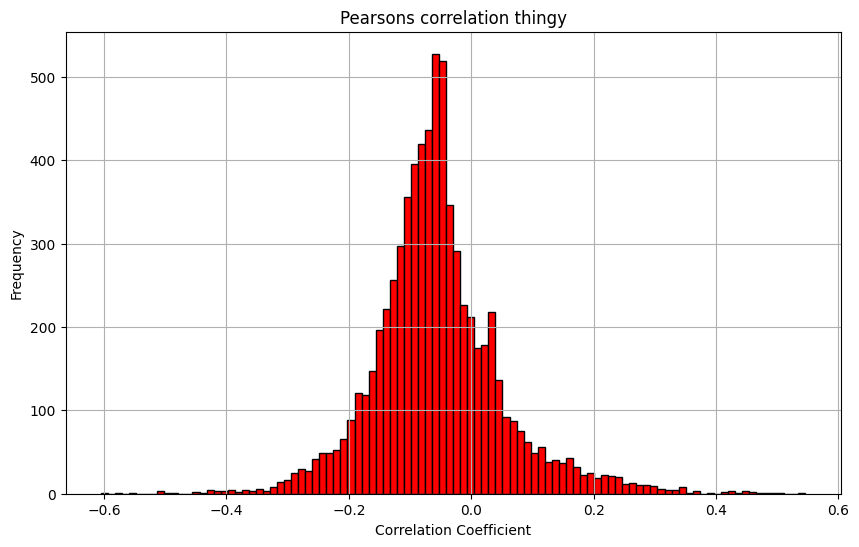

features with correlation above 0.5 or below -0.5
     Feature  Correlation
114   K00164    -0.575967
165   K00254    -0.506994
915   K01589    -0.605158
923   K01599    -0.510485
1052  K01772    -0.558126
1373  K02259    -0.505812
2508  K04070     0.503577
2837  K05919     0.546010


In [2]:
''' Calculating Pearsons coefficient'''
# Always look at data, right?
# print(X_aligned.head())



'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Finding pearsons
corr_coefficients = [] # stores coefficents from X_aligned and Y_aligned 
features = [] # stores feature names
# I should probably check how pearsons actually works


for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)
    features.append(column)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Pearsons correlation thingy')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# trying to find filter for features
correlations_df = pd.DataFrame({'Feature': features, 'Correlation': corr_coefficients})


# Filtering features
significant_correlations = correlations_df[(correlations_df['Correlation'] > 0.5) | (correlations_df['Correlation'] < -0.5)]
print("features with correlation above 0.5 or below -0.5")
print(significant_correlations)








In [6]:
''' Pipeline implementation for Naive bayes and random forests'''
start_time = time.time()

X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)


# Model pipeline configs
model_configs = [
    {
        'name': 'BernoulliNB',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', BernoulliNB())
        ]),
        'param_grid': {
            'select_k__k': [1],
            'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  # Manages problem of zero probability in dataset (if a value is not observed in the data, it makes sure that the probability of zero does not lead to incorrect predicitons)
            'estimator__binarize': [0.0]  # Is automatically applied, so Blackbox hehehe
        }
    },
    {
        'name': 'Logistic regression',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', LogisticRegression())
        ]),
        'param_grid': {
            'select_k__k' : [1],
            'estimator': [LogisticRegression()],
            'estimator__C': [0.01, 0.1, 1, 10, 100] # Regularization step- Smaller C equals stronger regularization(penalizes magnitude of coefficients)
        }
    },
    {
        'name': 'RandomForestClassifier',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', RandomForestClassifier(random_state=42)) 
        ]),
        'param_grid': {
            'select_k__k': [1],
            'estimator__n_estimators': [100], # Number of trees in the model i think
            'estimator__max_depth': [5, 10, 50, None] # Depth of each tree in the forest, None means no limit, depth runs untill all leaves are pure
        }
    },
    {
        'name': 'SVC', # Aims to best separate data into classes, does this by multidimensional classification
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', SVC(random_state=42))
        ]),
        'param_grid': {
            'select_k__k': [1],
            'estimator__C': [0.1, 1, 10], # Essentially makes sure that the data is not overfitted on the traning data by regularization. Low values mean more regularization, high means less regularization
            'estimator__kernel': ['linear', 'poly', 'rbf'], # Linear implies that data is not transformed and is linearly separable
            'estimator__gamma': ['scale', 'auto'] # How far does the influence of a single traing example reach?
        }
    }
]




# Perform GridSearchCV for each model configuration
for config in model_configs:
    # Grid searches across all the different estimators
    grid_search = GridSearchCV(config['pipeline'], config['param_grid'], cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train) # fits model

    best_model = grid_search.best_estimator_ # evaluates the best model of all the grid searches, i think. CHECK THIS
    Y_pred = best_model.predict(X_test)
    
    # Calculate and print metrics for the best model of this type
    f1 = f1_score(Y_test, Y_pred, average='macro')
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"{config['name']} - Best F1 Score (Macro): {f1:.3f}, Accuracy: {accuracy:.3f}")

    # Prints best parameters for each estimator
    print(f'Best parameters found for {config['name']}: {grid_search.best_params_}')

    # Checks MCC for each estimator
    mcc = matthews_corrcoef(Y_test, Y_pred)
    print(f"Matthews Correlation Coefficient for {config['name']}: {mcc}")
    print('\n')




''' Testing MCC things '''
print(f'Using, {grid_search.best_estimator_} for this instance')
best_model = grid_search.best_estimator_


selected_features = best_model.named_steps['select_k'].get_support(indices=True) # Extract the best single feature used by the model
best_feature = X_train.columns[selected_features[0]]

print(f"Best single feature selected: {best_feature}")


Y_pred = best_model.predict(X_test) # Predict on the test set using the best model

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"MCC for the trained model using k=1 (best feature): {mcc}")

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
BernoulliNB - Best F1 Score (Macro): 0.806, Accuracy: 0.877
Best parameters found for BernoulliNB: {'estimator__alpha': 0.01, 'estimator__binarize': 0.0, 'select_k__k': 1}
Matthews Correlation Coefficient for BernoulliNB: 0.6144474152233103


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Logistic regression - Best F1 Score (Macro): 0.806, Accuracy: 0.877
Best parameters found for Logistic regression: {'estimator': LogisticRegression(), 'estimator__C': 0.1, 'select_k__k': 1}
Matthews Correlation Coefficient for Logistic regression: 0.6144474152233103


Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier - Best F1 Score (Macro): 0.806, Accuracy: 0.877
Best parameters found for RandomForestClassifier: {'estimator__max_depth': 5, 'estimator__n_estimators': 100, 'select_k__k': 1}
Matthews Correlation Coefficient for RandomForestClassifier: 0.6144474152233103


Fitting 5 folds for each of

Most selected KO terms for predicting oxygen trait in hierchical manner (F score):
Index(['K01589', 'K00164', 'K01772', 'K05919', 'K01599', 'K00254', 'K02259',
       'K04070', 'K02257', 'K01163', 'K13628', 'K02823', 'K07138', 'K01677',
       'K16951', 'K00940', 'K11358', 'K17828', 'K00176', 'K01679', 'K03644',
       'K09157', 'K00674', 'K07166', 'K01902', 'K03737', 'K01903', 'K07146',
       'K03635', 'K22405', 'K00177', 'K18330', 'K03575', 'K03801', 'K06980',
       'K01633', 'K00241', 'K02276', 'K00658', 'K06891', 'K00390', 'K15635',
       'K07735', 'K10563', 'K03118', 'K01698', 'K01719', 'K03660', 'K00610',
       'K00533'],
      dtype='object', name='KO')


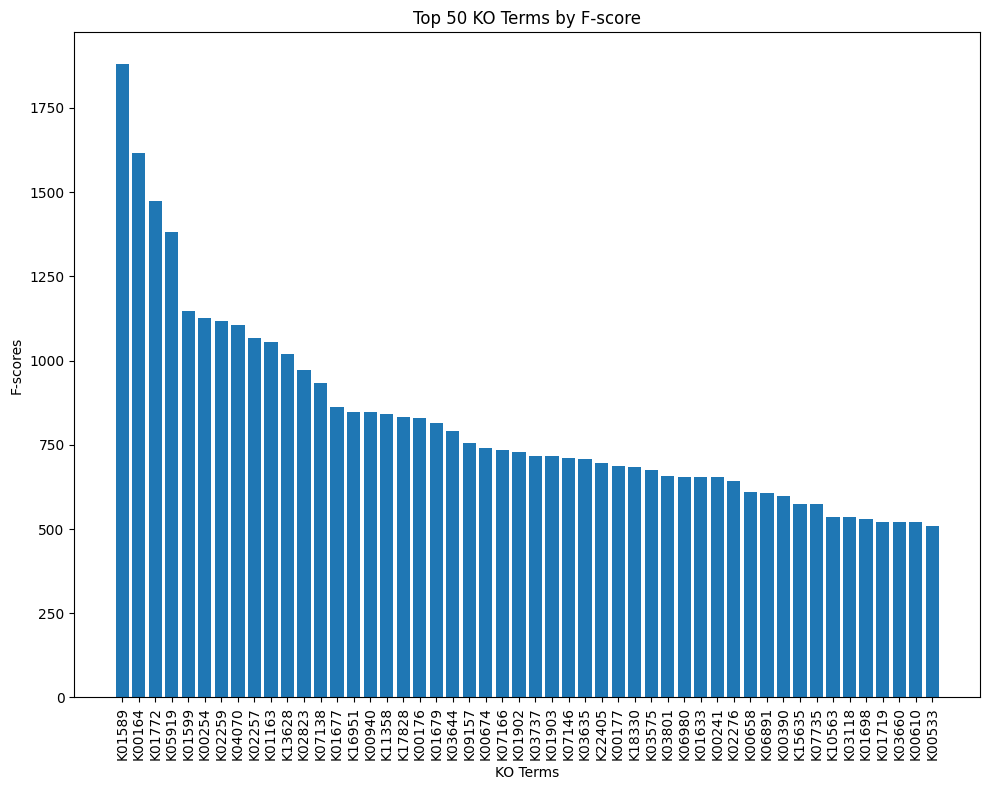

In [12]:
''' Finding best traits '''

# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=50)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

''' Plot for visualizing distribution and importance of best traits'''

# bar plot shows distribution of F-scores for the selected features
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_features)), sorted_scores)
plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
plt.xlabel('KO Terms')
plt.ylabel('F-scores')
plt.title('Top 50 KO Terms by F-score')
plt.tight_layout()  
plt.show()


In [ ]:
''' Label encoding '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()
#Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)
#Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded
#inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")


Processing estimator: {'name': 'BernoulliNB', 'pipeline': Pipeline(steps=[('select_k', SelectKBest()), ('estimator', BernoulliNB())]), 'param_grid': {'select_k__k': [10, 25, 50, 100, 250, 500, 1000], 'estimator__alpha': [0.01, 0.1, 1.0, 10.0], 'estimator__binarize': [0.0]}}
Testing with k=10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Testing with k=25
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Testing with k=50
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Testing with k=100
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Testing with k=250
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Testing with k=500
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Testing with k=1000
Fitting 5 folds for each of 4 candidates, totalling 20 fits


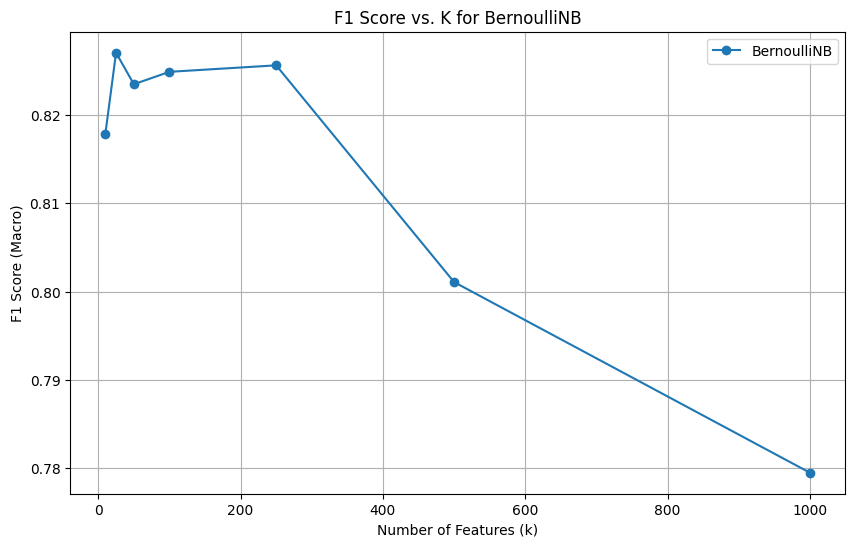

BernoulliNB - Best F1 Score (Macro): 0.827 at k=25
Processing estimator: {'name': 'Logistic regression', 'pipeline': Pipeline(steps=[('select_k', SelectKBest()),
                ('estimator', LogisticRegression())]), 'param_grid': {'select_k__k': [10, 25, 50, 100, 250, 500, 1000], 'estimator': [LogisticRegression()], 'estimator__C': [0.01, 0.1, 1, 10, 100]}}
Testing with k=10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Testing with k=25
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Testing with k=50
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Testing with k=100
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Testing with k=250
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Testing with k=500
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Testing with k=1000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


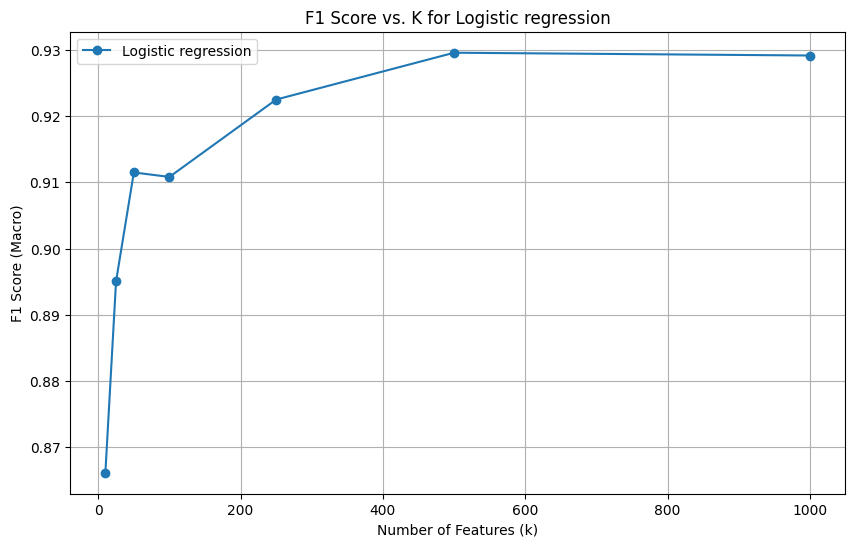

Logistic regression - Best F1 Score (Macro): 0.930 at k=500
Processing estimator: {'name': 'RandomForestClassifier', 'pipeline': Pipeline(steps=[('select_k', SelectKBest()),
                ('estimator', RandomForestClassifier(random_state=42))]), 'param_grid': {'select_k__k': [10, 25, 50, 100, 250, 500, 1000], 'estimator__n_estimators': [100, 200, 500], 'estimator__max_depth': [5, 10, 50, None]}}
Testing with k=10
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Testing with k=25
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Testing with k=50
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Testing with k=100
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Testing with k=250
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Testing with k=500
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Testing with k=1000
Fitting 5 folds for each of 12 candidates, totalling 60 fits


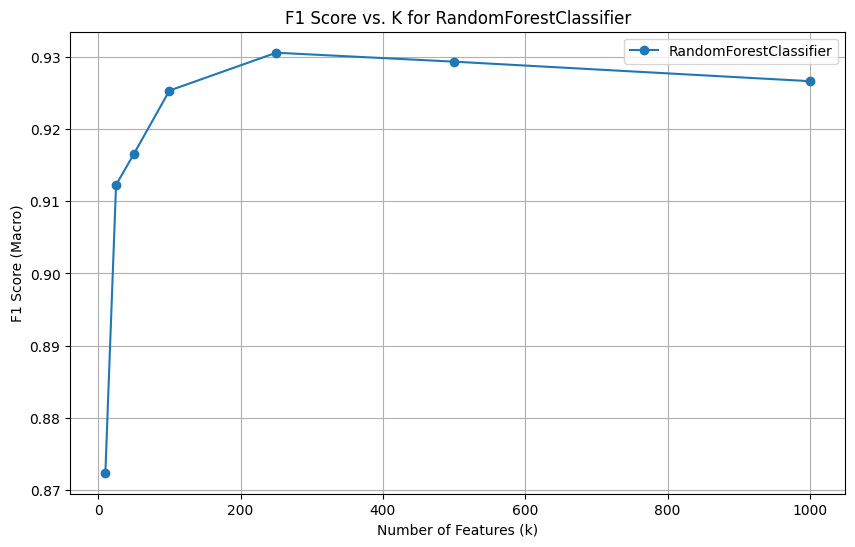

RandomForestClassifier - Best F1 Score (Macro): 0.931 at k=250
Processing estimator: {'name': 'SVC', 'pipeline': Pipeline(steps=[('select_k', SelectKBest()),
                ('estimator', SVC(random_state=42))]), 'param_grid': {'select_k__k': [10, 25, 50, 100, 250, 500, 1000], 'estimator__C': [0.1, 1, 10], 'estimator__kernel': ['linear', 'poly', 'rbf'], 'estimator__gamma': ['scale', 'auto']}}
Testing with k=10
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Testing with k=25
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Testing with k=50
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Testing with k=100
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Testing with k=250
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Testing with k=500
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Testing with k=1000
Fitting 5 folds for each of 18 candidates, totalling 90 fits


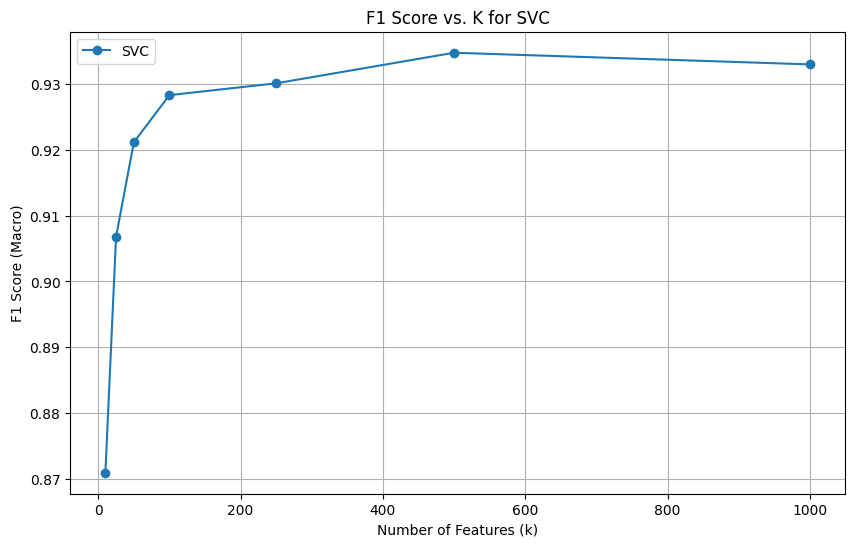

SVC - Best F1 Score (Macro): 0.935 at k=500


In [31]:
''' K values versus f1 score plot'''

# MOdel configs
model_configs = [
    {
        'name': 'BernoulliNB',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', BernoulliNB())
        ]),
        'param_grid': {
            'select_k__k': [10,25, 50, 100, 250, 500, 1000],
            'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  # Manages problem of zero probability in dataset (if a value is not observed in the data, it makes sure that the probability of zero does not lead to incorrect predicitons)
            'estimator__binarize': [0.0]  # Is automatically applied, so Blackbox hehehe
        }
    },
    {
        'name': 'Logistic regression',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', LogisticRegression())
        ]),
        'param_grid': {
            'select_k__k' : [10,25, 50, 100, 250, 500, 1000],
            'estimator': [LogisticRegression()],
            'estimator__C': [0.01, 0.1, 1, 10, 100] # Regularization step- Smaller C equals stronger regularization(penalizes magnitude of coefficients)
        }
    },
    {
        'name': 'RandomForestClassifier',
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', RandomForestClassifier(random_state=42)) 
        ]),
        'param_grid': {
            'select_k__k': [10,25, 50, 100, 250, 500, 1000],
            'estimator__n_estimators': [100, 200, 500], # Number of trees in the model i think
            'estimator__max_depth': [5, 10, 50, None] # Depth of each tree in the forest, None means no limit, depth runs untill all leaves are pure
        }
    },
    {
        'name': 'SVC', # Aims to best separate data into classes, does this by multidimensional classification
        'pipeline': Pipeline([
            ('select_k', SelectKBest(f_classif)),
            ('estimator', SVC(random_state=42))
        ]),
        'param_grid': {
            'select_k__k': [10,25, 50, 100, 250, 500, 1000],
            'estimator__C': [0.1, 1, 10], # Essentially makes sure that the data is not overfitted on the traning data by regularization. Low values mean more regularization, high means less regularization
            'estimator__kernel': ['linear', 'poly', 'rbf'], # Linear implies that data is not transformed and is linearly separable
            'estimator__gamma': ['scale', 'auto'] # How far does the influence of a single traing example reach?
        }
    }
]

# Loop through each model configuration
for config in model_configs:
    k_values = config['param_grid']['select_k__k']  # Extract k values from the current configuration's param_grid
    f1_scores = []  # To store mean F1 scores for each k
    print(f"Processing estimator: {config}")
    
    # Perform GridSearchCV for each k value to find the best F1 score
    for k in k_values:
        print(f"Testing with k={k}")
        config['param_grid']['select_k__k'] = [k]  
        grid_search = GridSearchCV(config['pipeline'], config['param_grid'], cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, Y_train)
        
        # Store the best F1 score for the current k
        f1_scores.append(grid_search.best_score_)
    
    # Plot F1 scores vs. k for the current estimator
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, f1_scores, marker='o', linestyle='-', label=config['name'])
    plt.xlabel('Number of Features (k)')
    plt.ylabel('F1 Score (Macro)')
    plt.title(f'F1 Score vs. K for {config['name']}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Find and print the best overall performance for the current estimator
    max_f1_index = np.argmax(f1_scores)  # Index of the best F1 score
    best_k = k_values[max_f1_index]  # k value for the best F1 score
    print(f"{config['name']} - Best F1 Score (Macro): {f1_scores[max_f1_index]:.3f} at k={best_k}")
